In [257]:
! pip install seaborn

In [67]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import matplotlib.colors as colors
import matplotlib.cm as cm  # Para usar un colormap
from scipy.interpolate import interp1d
import seaborn as sns
from scipy.stats import binned_statistic
from matplotlib.lines import Line2D
import matplotlib.cm as cm


In [78]:
TNG = np.load('labels.npy')

In [79]:
TNG.shape

(2972, 3, 20)

In [40]:
pars = []
TNG_pars = np.loadtxt('/home/jovyan/Data/Parameters/IllustrisTNG/CosmoAstroSeed_IllustrisTNG_L25n256_LH.txt', skiprows=1, usecols = (1,2,3,4,5,6))
Astrid_pars = np.loadtxt('/home/jovyan/Data/Parameters/Astrid/CosmoAstroSeed_Astrid_L25n256_LH.txt', skiprows=1, usecols = (1,2,3,4,5,6))
SIMBA_pars = np.loadtxt('/home/jovyan/Data/Parameters/SIMBA/CosmoAstroSeed_SIMBA_L25n256_LH.txt', skiprows=1, usecols = (1,2,3,4,5,6))
# pars[:,0] = Omega_m
# pars[:,1] = sigma_8
# pars[:,2] = A_SN1
# pars[:,3] = A_AGN1
# pars[:,4] = A_SN2
# pars[:,5] = A_AGN2
pars.append(TNG_pars)
pars.append(Astrid_pars)
pars.append(SIMBA_pars)

In [46]:
pars[0].shape

(1000, 6)

In [18]:
R_bins = np.geomspace(1,100,20)

def analyse_sim(simu, sim = 'TNG'):
    f_snapshot = '/home/jovyan/Data/Sims/' + simu + '/snapshot_090.hdf5'
    f_catalog  = '/home/jovyan/Data/FOF_Subfind/' + simu + '/groups_090.hdf5'

    catalog = h5py.File(f_catalog, 'r')
    snapshot = h5py.File(f_snapshot, 'r')
    h = snapshot['Header'].attrs[u'HubbleParam']    #value of the hubble parameter in 100 km/s/(Mpc/h)
    BoxSize = snapshot['Header'].attrs[u'BoxSize']/1e3
    # for the subhalos lets read their position, velocity
    pos_sh = catalog['Subhalo/SubhaloPos'][:]/1e3        #Mpc/h
    vel_sh = catalog['Subhalo/SubhaloVel'][:]            #km/s
    Nsub_h = catalog['Group/GroupNsubs'][:]
    lentype_h = catalog['Group/GroupLenType'][:]
    if sim == 'TNG':
        lentype_sh = catalog['Subhalo/SubhaloLenType'][:]
        mass_DM = snapshot['Header'].attrs[u'MassTable'][1]*1e10/h
    else:
        len_h  = catalog['Group/GroupLen'][:]
        len_sh = catalog['Subhalo/SubhaloLen'][:]
        IDs_sh = catalog['IDs/ID'][:]
        IDs_gas    = snapshot['PartType0/ParticleIDs'][:]
        IDs_dm     = snapshot['PartType1/ParticleIDs'][:]
        IDs_stars  = snapshot['PartType4/ParticleIDs'][:]
        pos_dm_full = snapshot['PartType1/Coordinates'][:]/h #kpc
        vel_dm_full = snapshot['PartType1/Velocities'][:]      #km/s  
        mass_dm_full = snapshot['PartType1/Masses'][:]*1e10 / h
        pos_stars_full = snapshot['PartType4/Coordinates'][:]/h #kpc
        vel_stars_full = snapshot['PartType4/Velocities'][:]      #km/s
        mass_stars_full = snapshot['PartType4/Masses'][:] * 1e10 / h # Msun 
        pos_gas_full = snapshot['PartType0/Coordinates'][:]/h #kpc
        vel_gas_full = snapshot['PartType0/Velocities'][:]      #km/s
        mass_gas_full = snapshot['PartType0/Masses'][:] * 1e10 / h # Msun
        
    index_h_sh = catalog['Subhalo/SubhaloGrNr']
    
    # Let's look for the subhalos
    subhalo_ind = np.where( (catalog['Subhalo']['SubhaloMassType'][()][:,4] * 1e10 / h < 1e12) & 
                            (catalog['Subhalo']['SubhaloMassType'][()][:,4] * 1e10 / h > 1e10) &
                            (catalog['Subhalo']['SubhaloSFR'][()] > 0.1))[0]

    # for each subhalo let's compute their profiles
    profiles = np.zeros((len(subhalo_ind),3,20))
    
    for i in tqdm(range(len(subhalo_ind))):
        index_sh = subhalo_ind[i]
        pos_sub = pos_sh[index_sh] * 1e3 / h # kPc
        vel_sub = vel_sh[index_sh]
        index_h = index_h_sh[index_sh]
        
        Nsub_prev_groups = np.sum(Nsub_h[:index_h]) #This is the number of subhalos that the preceeding halos
        
        # The number of subhalos that preceed our subhalo in the halo it belongs to is
        preceeding_subhalos_in_halo = index_sh - Nsub_prev_groups

        if sim == 'TNG':
            start = np.sum(lentype_h[:index_h],axis=0) + np.sum(lentype_sh[Nsub_prev_groups:index_sh],axis=0)
            end = start + lentype_sh[index_sh]
            pos_dm = snapshot['PartType1/Coordinates'][start[1]:end[1]]/h #kpc
            vel_dm = snapshot['PartType1/Velocities'][start[1]:end[1]]      #km/s  
            mass_dm = np.ones(len(pos_dm)) * mass_DM
            pos_stars = snapshot['PartType4/Coordinates'][start[4]:end[4]]/h #kpc
            vel_stars = snapshot['PartType4/Velocities'][start[4]:end[4]]      #km/s
            mass_stars = snapshot['PartType4/Masses'][start[4]:end[4]] * 1e10 / h # Msun    
            pos_gas = snapshot['PartType0/Coordinates'][start[0]:end[0]]/h #kpc
            vel_gas = snapshot['PartType0/Velocities'][start[0]:end[0]]      #km/s
            mass_gas = snapshot['PartType0/Masses'][start[0]:end[0]] * 1e10 / h # Msun 
        else:
            start = np.sum(len_h[:index_h]) + np.sum(len_sh[Nsub_prev_groups:index_sh])
            end = start + len_sh[index_sh]
            indexes = IDs_sh[start:end]
            common_indexes, indexes1, indexes2 = np.intersect1d(IDs_dm, indexes, assume_unique=False, return_indices=True)
            indexes1 = np.sort(indexes1)
            pos_dm = pos_dm_full[indexes1]
            vel_dm = vel_dm_full[indexes1]      #km/s  
            mass_dm = mass_dm_full[indexes1]
            common_indexes, indexes1, indexes2 = np.intersect1d(IDs_stars, indexes, assume_unique=False, return_indices=True)
            indexes1 = np.sort(indexes1)
            pos_stars = pos_stars_full[indexes1]
            vel_stars = vel_stars_full[indexes1]      #km/s
            mass_stars = mass_stars_full[indexes1]  
            common_indexes, indexes1, indexes2 = np.intersect1d(IDs_gas, indexes, assume_unique=False, return_indices=True)
            indexes1 = np.sort(indexes1)
            pos_gas = pos_gas_full[indexes1]
            vel_gas = vel_gas_full[indexes1]      #km/s
            mass_gas = mass_gas_full[indexes1]    


        # Let's move the coordinates if they are near the border
        aux_ind = np.where( (pos_stars[:, 0] - pos_sub[0]) > (BoxSize / 2) )[0]
        pos_stars[aux_ind, 0] = pos_stars[aux_ind, 0] - BoxSize
        aux_ind = np.where( (pos_sub[0] - pos_stars[:, 0]) > (BoxSize / 2) )[0]
        pos_stars[aux_ind, 0] = pos_stars[aux_ind, 0] + BoxSize
        aux_ind = np.where( (pos_stars[:, 1] - pos_sub[1]) > (BoxSize / 2) )[0]
        pos_stars[aux_ind, 1] = pos_stars[aux_ind, 1] - BoxSize
        aux_ind = np.where( (pos_sub[1] - pos_stars[:, 1]) > (BoxSize / 2) )[0]
        pos_stars[aux_ind, 1] = pos_stars[aux_ind, 1] + BoxSize
        aux_ind = np.where( (pos_stars[:, 2] - pos_sub[2]) > (BoxSize / 2) )[0]
        pos_stars[aux_ind, 2] = pos_stars[aux_ind, 2] - BoxSize
        aux_ind = np.where( (pos_sub[2] - pos_stars[:, 2]) > (BoxSize / 2) )[0]
        pos_stars[aux_ind, 2] = pos_stars[aux_ind, 2] + BoxSize
        
        aux_ind = np.where( (pos_dm[:, 0] - pos_sub[0]) > (BoxSize / 2) )[0]
        pos_dm[aux_ind, 0] = pos_dm[aux_ind, 0] - BoxSize
        aux_ind = np.where( (pos_sub[0] - pos_dm[:, 0]) > (BoxSize / 2) )[0]
        pos_dm[aux_ind, 0] = pos_dm[aux_ind, 0] + BoxSize
        aux_ind = np.where( (pos_dm[:, 1] - pos_sub[1]) > (BoxSize / 2) )[0]
        pos_dm[aux_ind, 1] = pos_dm[aux_ind, 1] - BoxSize
        aux_ind = np.where( (pos_sub[1] - pos_dm[:, 1]) > (BoxSize / 2) )[0]
        pos_dm[aux_ind, 1] = pos_dm[aux_ind, 1] + BoxSize
        aux_ind = np.where( (pos_dm[:, 2] - pos_sub[2]) > (BoxSize / 2) )[0]
        pos_dm[aux_ind, 2] = pos_dm[aux_ind, 2] - BoxSize
        aux_ind = np.where( (pos_sub[2] - pos_dm[:, 2]) > (BoxSize / 2) )[0]
        pos_dm[aux_ind, 2] = pos_dm[aux_ind, 2] + BoxSize
        
        aux_ind = np.where( (pos_gas[:, 0] - pos_sub[0]) > (BoxSize / 2) )[0]
        pos_gas[aux_ind, 0] = pos_gas[aux_ind, 0] - BoxSize
        aux_ind = np.where( (pos_sub[0] - pos_gas[:, 0]) > (BoxSize / 2) )[0]
        pos_gas[aux_ind, 0] = pos_gas[aux_ind, 0] + BoxSize
        aux_ind = np.where( (pos_gas[:, 1] - pos_sub[1]) > (BoxSize / 2) )[0]
        pos_gas[aux_ind, 1] = pos_gas[aux_ind, 1] - BoxSize
        aux_ind = np.where( (pos_sub[1] - pos_gas[:, 1]) > (BoxSize / 2) )[0]
        pos_gas[aux_ind, 1] = pos_gas[aux_ind, 1] + BoxSize
        aux_ind = np.where( (pos_gas[:, 2] - pos_sub[2]) > (BoxSize / 2) )[0]
        pos_gas[aux_ind, 2] = pos_gas[aux_ind, 2] - BoxSize
        aux_ind = np.where( (pos_sub[2] - pos_gas[:, 2]) > (BoxSize / 2) )[0]
        pos_gas[aux_ind, 2] = pos_gas[aux_ind, 2] + BoxSize

         # ------------------Let's center the particles -----------
        pos_stars = pos_stars - pos_sub
        vel_stars = vel_stars - vel_sub
        
        vel_dm = vel_dm - vel_sub
        pos_dm = pos_dm - pos_sub
        
        pos_gas = pos_gas - pos_sub
        vel_gas = vel_gas - vel_sub


        dist = np.linalg.norm(pos_stars, axis=1)
        M_stars = np.array([np.sum( mass_stars[np.where(np.array(dist) < R)[0]] ) for R in R_bins])
        
        dist = np.linalg.norm(pos_gas, axis=1)
        M_gas = np.array([np.sum( mass_gas[np.where(np.array(dist) < R)[0]] ) for R in R_bins])
        
        dist = np.linalg.norm(pos_dm, axis=1)
        M_dm = np.array([np.sum( mass_dm[np.where(np.array(dist) < R)[0]] ) for R in R_bins])

        profiles[i,0,:] = M_stars
        profiles[i,1,:] = M_gas
        profiles[i,2,:] = M_dm
    catalog.close()
    snapshot.close()
    
    return  profiles

In [44]:
prof_CV_simba = []
for i in range(5):
    prof_CV_simba.append( analyse_sim('SIMBA/L25n256/CV/CV_' + str(i), sim = 'Simba') )

100%|██████████| 103/103 [08:57<00:00,  5.22s/it]


In [36]:
prof_LH_simba = []
for i in range(1):
    prof_LH_simba.append( analyse_sim('SIMBA/L25n256/LH/LH_' + str(i), sim = 'Simba') )

100%|██████████| 40/40 [03:43<00:00,  5.60s/it]


In [ ]:
prof_CV_astrid = []
for i in range(5):
    prof_CV_astrid.append( analyse_sim('Astrid/L25n256/CV/CV_' + str(i), sim = 'Astrid') )

 68%|██████▊   | 44/65 [05:09<02:26,  6.98s/it]

In [37]:
prof_LH_astrid = []
for i in range(50):
    prof_LH_astrid.append( analyse_sim('Astrid/L25n256/LH/LH_' + str(i), sim = 'Astrid') )

100%|██████████| 1/1 [00:08<00:00,  8.22s/it]


In [32]:
prof_LH = []
for i in range(50):
    prof_LH.append( analyse_sim('IllustrisTNG/LH/LH_' + str(i), sim = 'TNG') )

100%|██████████| 45/45 [00:03<00:00, 14.86it/s]


In [33]:
prof_CV = []
for i in range(50):
    prof_CV.append( analyse_sim('IllustrisTNG/CV/CV_' + str(i), sim = 'TNG') )

100%|██████████| 82/82 [00:07<00:00, 10.92it/s]


FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = '/home/jovyan/Data/FOF_Subfind/IllustrisTNG/CV/CV_27/groups_090.hdf5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

/tmp/ipykernel_4513/2141172725.py:38: RuntimeWarning: divide by zero encountered in log10
  bin_means, bin_edges, binnumber = binned_statistic(np.log10(prof_CV[isim][:,0,nbin]), np.log10(prof_CV[isim][:,2,nbin]), 'median', bins=num_bins)
/tmp/ipykernel_4513/2141172725.py:78: RuntimeWarning: divide by zero encountered in log10
  bin_means, bin_edges, binnumber = binned_statistic(np.log10(prof_LH[isim][:,0,nbin]), np.log10(prof_LH[isim][:,2,nbin]), 'median', bins=num_bins)
/tmp/ipykernel_4513/2141172725.py:91: RuntimeWarning: divide by zero encountered in log10
  bin_means, bin_edges, binnumber = binned_statistic(np.log10(simu[irun][:,0,nbin]), np.log10(simu[irun][:,2,nbin]), 'median', bins=num_bins)


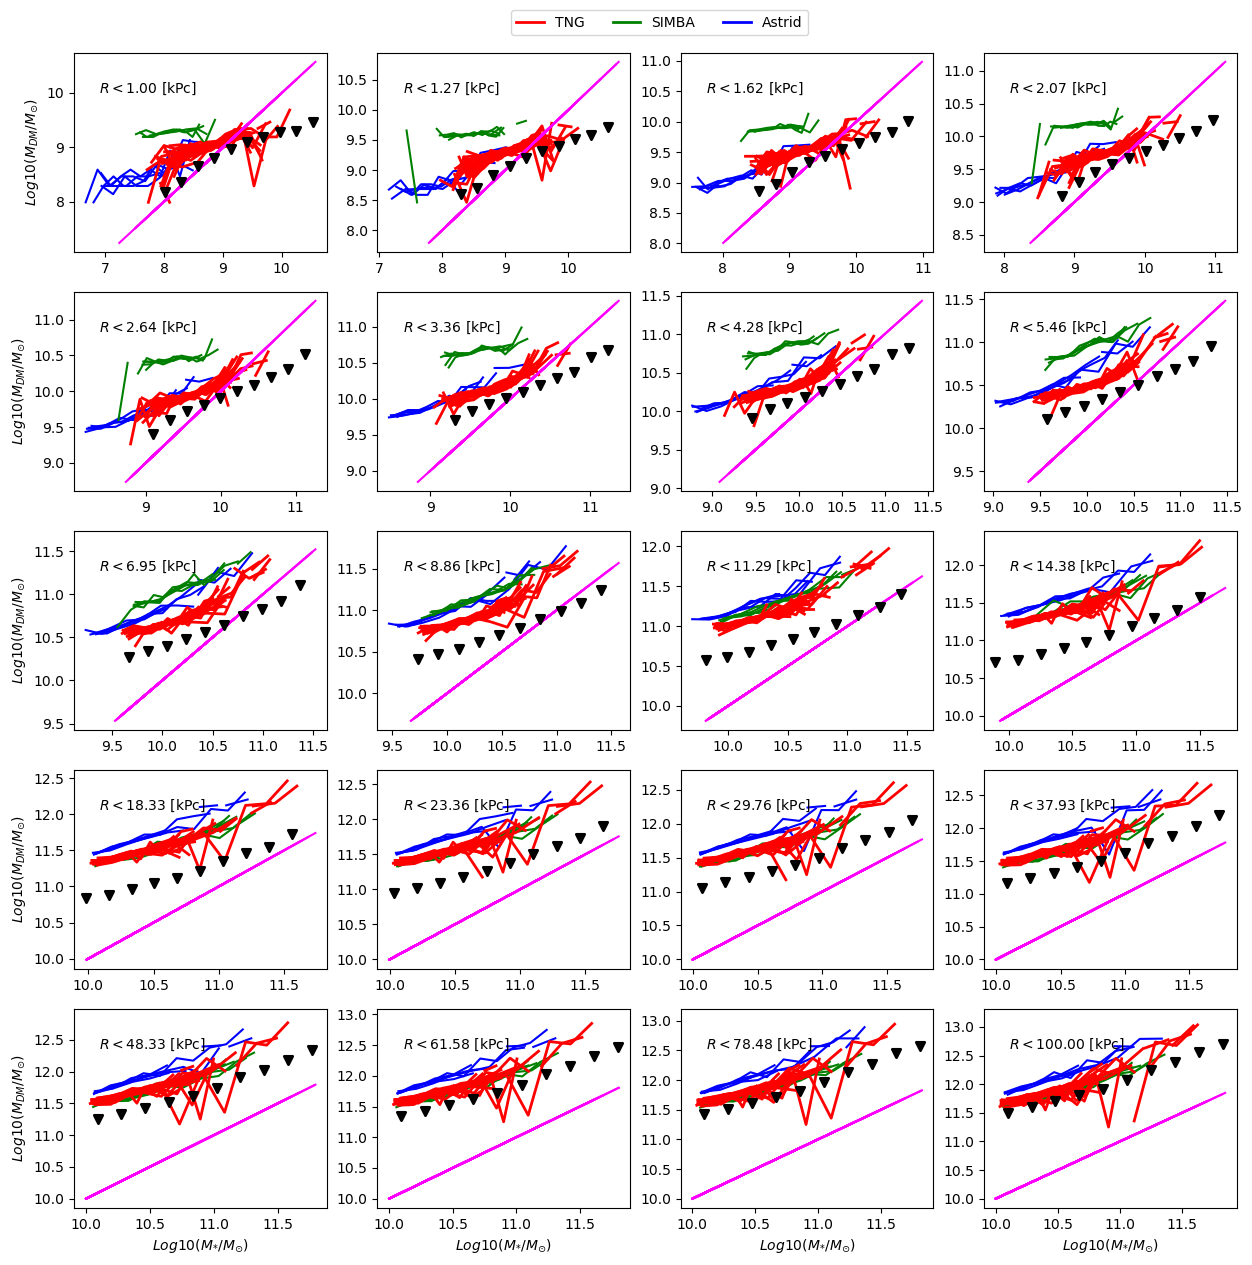

In [85]:
num_bins = 10
norm = colors.Normalize(vmin=min(pars[0][:,4]), vmax=max(pars[0][:,4]))
#norm = colors.Normalize(vmin=0, vmax=len(prof_LH))
colormap = cm.viridis  # Puedes usar otros colormaps: 'plasma', 'coolwarm', etc.

#bin_edges = np.linspace(np.log10(prof_CV[0][:,0,0]).min(), np.log10(prof_CV[0][:,0,0]).max(), num_bins + 1)
#bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

fig,ax = plt.subplots(5,4, figsize = (15,15))
axes = ax.flatten()

for isim in range(len(prof_CV)):
    for nbin in range(20):
        #%f = interp1d(np.log10(prof_CV[isim][:,0,nbin]), np.log10(prof_CV[isim][:,2,nbin]), fill_value=(np.log10(prof_CV[isim][:,2,nbin]).min(), np.log10(prof_CV[isim][:,2,nbin]).max()), bounds_error=False)
        #%coeffs = np.polyfit(np.log10(prof_CV[isim][:,0,nbin]), np.log10(prof_CV[isim][:,2,nbin]), 1) 

        #axes[nbin].scatter(np.log10(prof_CV[isim][:,0,nbin]), np.log10(prof_CV[isim][:,2,nbin]), color = 'black')
        #%aux = np.linspace(np.log10(prof_CV[isim][:,0,nbin]).min(), np.log10(prof_CV[isim][:,0,nbin]).max(),10)
        #axes[nbin].plot(aux, f(aux), color = 'black')
        
        #%y_fit = np.polyval(coeffs, aux)
        #%axes[nbin].plot(aux, y_fit, color = 'black')
        
        # Bins: recolectar listas de y's por bin
        #%binned_ys = [[] for _ in range(num_bins)]
        #%for x, y in zip(np.log10(prof_CV[isim][:,0,nbin]), np.log10(prof_CV[isim][:,2,nbin])):
        #%    bin_index = np.digitize(x, bin_edges) - 1
        #%    if 0 <= bin_index < num_bins:
        #%        binned_ys[bin_index].append(y)
        
        #%valid_data = [(bin_centers[j], binned_ys[j]) for j in range(num_bins) if len(binned_ys[j]) > 0]
        #%positions = [x for x, ys in valid_data]
        #%data = [ys for x, ys in valid_data]
        
        # Hacer el violin plot
        #%parts = axes[nbin].violinplot(data, positions=positions, widths=0.1, showmeans=False, showmedians=True, showextrema=True)

        bin_means, bin_edges, binnumber = binned_statistic(np.log10(prof_CV[isim][:,0,nbin]), np.log10(prof_CV[isim][:,2,nbin]), 'median', bins=num_bins)
        bin_width = (bin_edges[1] - bin_edges[0])
        bin_centers = bin_edges[1:] - bin_width/2
        axes[nbin].plot(bin_centers, bin_means, c = 'red', lw=2, zorder = 1)
        axes[nbin].set_ylabel('')
        axes[nbin].set_xlabel('')
        axes[nbin].plot([np.log10(prof_CV[isim][:,0,nbin]).min(), np.log10(prof_CV[isim][:,0,nbin]).max()],
                        [np.log10(prof_CV[isim][:,0,nbin]).min(), np.log10(prof_CV[isim][:,0,nbin]).max()], color = 'magenta')

for isim in range(len(prof_LH)):
    for nbin in range(20):
        try:
            #%f = interp1d(np.log10(prof_LH[isim][:,0,nbin]), np.log10(prof_LH[isim][:,2,nbin]), fill_value=(np.log10(prof_LH[isim][:,2,nbin]).min(), np.log10(prof_LH[isim][:,2,nbin]).max()), bounds_error=False)
            #%coeffs = np.polyfit(np.log10(prof_LH[isim][:,0,nbin]), np.log10(prof_LH[isim][:,2,nbin]), 1) 
            #%aux = np.linspace(np.log10(prof_LH[isim][:,0,nbin]).min(), np.log10(prof_LH[isim][:,0,nbin]).max(),10)
            
            #%y_fit = np.polyval(coeffs, aux)
            #%axes[nbin].plot(aux, y_fit, color =  colormap(norm(pars[isim,3])))
            #axes[nbin].plot(aux, f(aux), color =  colormap(norm(pars[isim,1])))
            #axes[nbin].scatter(np.log10(prof_LH[isim][:,0,nbin]), np.log10(prof_LH[isim][:,2,nbin]), color =  colormap(norm(isim)), zorder = 0)
            #bin_edges = np.linspace(np.log10(prof_LH[isim][:,0,nbin]).min(), np.log10(prof_LH[isim][:,0,nbin]).max(), num_bins + 1)
            #bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
            
            # Bins: recolectar listas de y's por bin
            #%binned_ys = [[] for _ in range(num_bins)]
            #%for x, y in zip(np.log10(prof_LH[isim][:,0,nbin]), np.log10(prof_LH[isim][:,2,nbin])):
            #%    bin_index = np.digitize(x, bin_edges) - 1
            #%    if 0 <= bin_index < num_bins:
            #%        binned_ys[bin_index].append(y)
            
            #%valid_data = [(bin_centers[j], binned_ys[j]) for j in range(num_bins) if len(binned_ys[j]) > 0]
            #%positions = [x for x, ys in valid_data]
            #%data = [ys for x, ys in valid_data]
            
            # Hacer el violin plot
            #%parts = axes[nbin].violinplot(data, positions=positions, widths=0.1, showmeans=False, showmedians=True, showextrema=True)
            #%for pc in parts['bodies']:
            #%    pc.set_facecolor(colormap(norm(isim)))
            #%    pc.set_edgecolor(colormap(norm(isim)))
            #%    pc.set_alpha(0.7)
            bin_means, bin_edges, binnumber = binned_statistic(np.log10(prof_LH[isim][:,0,nbin]), np.log10(prof_LH[isim][:,2,nbin]), 'median', bins=num_bins)
            bin_width = (bin_edges[1] - bin_edges[0])
            bin_centers = bin_edges[1:] - bin_width/2
            #axes[nbin].plot(bin_centers, bin_means, color =  colormap(norm(pars[0][isim,4])), zorder = 0)
        except:
            pass

pars = [Astrid_pars,Astrid_pars]
sim_colors = ['blue', 'green']
for isimu, simu in enumerate([prof_CV_astrid,prof_CV_simba]):
    for irun in range(len(simu)):
        for nbin in range(20):
            try:
                bin_means, bin_edges, binnumber = binned_statistic(np.log10(simu[irun][:,0,nbin]), np.log10(simu[irun][:,2,nbin]), 'median', bins=num_bins)
                bin_width = (bin_edges[1] - bin_edges[0])
                bin_centers = bin_edges[1:] - bin_width/2
                #axes[nbin].plot(bin_centers, bin_means, color = colormap(norm(pars[isimu][irun,3])), zorder = 0)
                axes[nbin].plot(bin_centers, bin_means, color = sim_colors[isimu], zorder = 0)
            except:
                pass

for i in range(20):
    #axes[i].scatter(np.log10(TNG[:,1,i]),np.log10(TNG[:,0,i]), color = 'black')
    bin_means, bin_edges, binnumber = binned_statistic(np.log10(TNG[:,1,i]),np.log10(TNG[:,0,i]), 'median', bins=num_bins)
    bin_width = (bin_edges[1] - bin_edges[0])
    bin_centers = bin_edges[1:] - bin_width/2
    axes[i].scatter(bin_centers, bin_means, color = 'black', zorder = 20, lw = 2, marker = 'v')
for i in range(len(axes)):
    axes[i].text(0.1,0.8,'$R < {:.2f}$ [kPc]'.format(R_bins[i]), transform = axes[i].transAxes)
    
ax[4,0].set_xlabel(r'$Log10(M_{*} / M_{\odot})$')
ax[4,1].set_xlabel(r'$Log10(M_{*} / M_{\odot})$')
ax[4,2].set_xlabel(r'$Log10(M_{*} / M_{\odot})$')
ax[4,3].set_xlabel(r'$Log10(M_{*} / M_{\odot})$')

ax[0,0].set_ylabel(r'$Log10(M_{DM} / M_{\odot})$')
ax[1,0].set_ylabel(r'$Log10(M_{DM} / M_{\odot})$')
ax[2,0].set_ylabel(r'$Log10(M_{DM} / M_{\odot})$')
ax[3,0].set_ylabel(r'$Log10(M_{DM} / M_{\odot})$')
ax[4,0].set_ylabel(r'$Log10(M_{DM} / M_{\odot})$')

legend_lines = [
    Line2D([0], [0], color='red', lw=2, label='TNG'),
    Line2D([0], [0], color='green', lw=2, label='SIMBA'),
    Line2D([0], [0], color='blue', lw=2, label='Astrid'),
]
axes[0].legend(handles=legend_lines, loc='upper left', bbox_to_anchor=(1.7, 1.25), ncol = 3)

#sm = cm.ScalarMappable(cmap='viridis', norm=norm)
#sm.set_array([])  # Requerido aunque no se use directamente
#cbar = fig.colorbar(sm, ax=axes[0], orientation='horizontal', shrink=0.7, pad=0.2, location = 'top' )

plt.savefig('stellar_vs_dm_CV.pdf', bbox_inches = 'tight')

In [52]:
!ls /home/jovyan/Data/Sims/

Astrid	   IllustrisTNG     SIMBA     Swift-EAGLE
Astrid_DM  IllustrisTNG_DM  SIMBA_DM  Swift-EAGLE_DM


In [19]:
# get the name of the snapshot and its corresponding Subfind catalog
f_snapshot = '/home/jovyan/Data/Sims/IllustrisTNG/L25n256/LH/LH_50/snapshot_090.hdf5'
f_catalog  = '/home/jovyan/Data/FOF_Subfind/IllustrisTNG/L25n256/LH/LH_50/groups_090.hdf5'

In [110]:
f = h5py.File(f_catalog, 'r')
print(f.keys())

<KeysViewHDF5 ['Config', 'Group', 'Header', 'IDs', 'Parameters', 'Subhalo']>


In [113]:
f['Parameters']

<HDF5 group "/Parameters" (0 members)>

In [21]:
print(f['Group'].keys(),'\n')
print(f['Subhalo'].keys())

<KeysViewHDF5 ['GroupBHMass', 'GroupBHMdot', 'GroupCM', 'GroupFirstSub', 'GroupGasMetalFractions', 'GroupGasMetallicity', 'GroupLen', 'GroupLenType', 'GroupMass', 'GroupMassType', 'GroupNsubs', 'GroupPos', 'GroupSFR', 'GroupStarMetalFractions', 'GroupStarMetallicity', 'GroupVel', 'GroupWindMass', 'Group_M_Crit200', 'Group_M_Crit500', 'Group_M_Mean200', 'Group_M_TopHat200', 'Group_R_Crit200', 'Group_R_Crit500', 'Group_R_Mean200', 'Group_R_TopHat200']> 

<KeysViewHDF5 ['SubhaloBHMass', 'SubhaloBHMdot', 'SubhaloBfldDisk', 'SubhaloBfldHalo', 'SubhaloCM', 'SubhaloGasMetalFractions', 'SubhaloGasMetalFractionsHalfRad', 'SubhaloGasMetalFractionsMaxRad', 'SubhaloGasMetalFractionsSfr', 'SubhaloGasMetalFractionsSfrWeighted', 'SubhaloGasMetallicity', 'SubhaloGasMetallicityHalfRad', 'SubhaloGasMetallicityMaxRad', 'SubhaloGasMetallicitySfr', 'SubhaloGasMetallicitySfrWeighted', 'SubhaloGrNr', 'SubhaloHalfmassRad', 'SubhaloHalfmassRadType', 'SubhaloIDMostbound', 'SubhaloLen', 'SubhaloLenType', 'Subhal

In [ ]:
snap = h5py.File(f_snapshot,'r')

In [75]:
snap['Header'].attrs.keys()

<KeysViewHDF5 ['BoxSize', 'Composition_vector_length', 'Flag_Cooling', 'Flag_DoublePrecision', 'Flag_Feedback', 'Flag_Metals', 'Flag_Sfr', 'Flag_StellarAge', 'Git_commit', 'Git_date', 'HubbleParam', 'MassTable', 'NumFilesPerSnapshot', 'NumPart_ThisFile', 'NumPart_Total', 'NumPart_Total_HighWord', 'Omega0', 'OmegaBaryon', 'OmegaLambda', 'Redshift', 'Time', 'UnitLength_in_cm', 'UnitMass_in_g', 'UnitVelocity_in_cm_per_s']>

In [84]:
BoxSize      = snap['Header'].attrs[u'BoxSize']/1e3    #size of the snapshot in comoving Mpc/h
redshift     = snap['Header'].attrs[u'Redshift']       #reshift of the snapshot
scale_factor = snap['Header'].attrs[u'Time']           #scale factor
h            = snap['Header'].attrs[u'HubbleParam']    #value of the hubble parameter in 100 km/s/(Mpc/h)
mass_dm       = snap['Header'].attrs[u'MassTable'][1]*1e10/h #masses of the particles in Msun/h
Np           = snap['Header'].attrs[u'NumPart_Total']  #total number of particles for specie
Omega_m      = snap['Header'].attrs[u'Omega0']         #Omega_matter
Omega_L      = snap['Header'].attrs[u'OmegaLambda']    #Omega_baryon
print('Total number of particles in the snapshot per type',Np)

Total number of particles in the snapshot per type [15733279 16777216        0        0   644321     1680]


In [39]:
ind = np.where( (f['Subhalo']['SubhaloMassType'][()][:,4] * 1e10 / h < 1e12) & 
          (f['Subhalo']['SubhaloMassType'][()][:,4] * 1e10 / h > 1e10) &
          (f['Subhalo']['SubhaloSFR'][()] > 0.1))[0]

(array([21., 19., 17.,  4.,  2.,  0.,  0.,  0.,  0.,  1.]),
 array([10.01306343, 10.16534424, 10.31762409, 10.4699049 , 10.62218475,
        10.77446556, 10.92674637, 11.07902622, 11.23130703, 11.38358688,
        11.53586769]),
 <BarContainer object of 10 artists>)

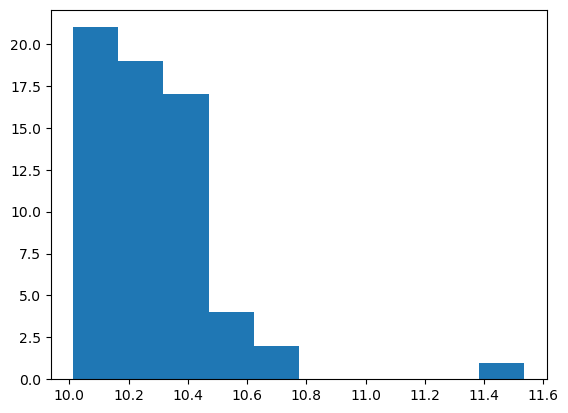

In [41]:
plt.hist(np.log10(f['Subhalo']['SubhaloMassType'][()][ind,4] * 1e10 / h))

In [5]:
# lets read the length of the FoF groups and the number of subhalos they contain
lentype_h = f['Group/GroupLenType'][:]
Nsub_h = f['Group/GroupNsubs'][:]

# for the subhalos lets read their position, mass, velocity, and SFR
pos_sh     = f['Subhalo/SubhaloPos'][:]/1e3        #Mpc/h
vel_sh     = f['Subhalo/SubhaloVel'][:]            #km/s
mass_sh    = f['Subhalo/SubhaloMassType'][:]*1e10  #Msun/h
SFR_sh     = f['Subhalo/SubhaloSFR'][:]            #Msun/yr
lentype_sh = f['Subhalo/SubhaloLenType'][:]
index_h_sh = f['Subhalo/SubhaloGrNr']

In [95]:
index_sh = ind[2]
pos_sub = pos_sh[index_sh] * 1e3 / h # kPc
vel_sub = vel_sh[index_sh]
print('position:',pos_sub,'kpc')
print('velocity:',vel_sub,'km/s')
print('mass:',mass_sh[index_sh],'Msun/h')
print('total length:',len_h[index_sh],'particles')
print('number of particles by type:',lentype_sh[index_sh])

position: [ 3791.833  25981.605   2313.8582] kpc
velocity: [ 181.98227 -181.83202  809.15234] km/s
mass: [6.4822845e+09 1.8068144e+11 0.0000000e+00 0.0000000e+00 1.3637612e+10
 3.6308956e+07] Msun/h
total length: 3180 particles
number of particles by type: [ 443 2212    0    0 1487    1]


In [7]:
len_h = f['Group/GroupLen'][:]

In [43]:
index_h = index_h_sh[index_sh] #index of the halos where this subhalo belongs to
print('This subhalo belongs to group %d'%index_h)

This subhalo belongs to group 1


In [44]:
Nsub_prev_groups = np.sum(Nsub_h[:index_h]) #This is the number of subhalos that the preceeding halos
print('The first %d halos contain %d subhalos'%(index_h,Nsub_prev_groups))

# The number of subhalos that preceed our subhalo in the halo it belongs to is
preceeding_subhalos_in_halo = index_sh - Nsub_prev_groups
print('There are %d subhalos that preceed our subhalo in the halo it belongs to'%preceeding_subhalos_in_halo)

The first 1 halos contain 327 subhalos
There are 6 subhalos that preceed our subhalo in the halo it belongs to


In [45]:
start = np.sum(lentype_h[:index_h],axis=0) + np.sum(lentype_sh[Nsub_prev_groups:index_sh],axis=0)
end = start + lentype_sh[index_sh]
print(start)
print(end)

[ 859621 1307096       0       0  104911      37]
[ 860064 1309308       0       0  106398      38]


In [94]:
pos_dm = snap['PartType1/Coordinates'][start[1]:end[1]]/h #kpc
vel_dm = snap['PartType1/Velocities'][start[1]:end[1]]      #km/s  
pos_stars = snap['PartType4/Coordinates'][start[4]:end[4]]/h #kpc
vel_stars = snap['PartType4/Velocities'][start[4]:end[4]]      #km/s
mass_stars = snap['PartType4/Masses'][start[4]:end[4]] * 1e10 / h # Msun    
pos_gas = snap['PartType0/Coordinates'][start[0]:end[0]]/h #kpc
vel_gas = snap['PartType0/Velocities'][start[0]:end[0]]      #km/s
mass_gas = snap['PartType0/Masses'][start[0]:end[0]] * 1e10 / h # Msun    
#snap.close()

In [54]:
pos_gas

array([[ 2.54451366, 17.43629051,  1.5530107 ],
       [ 2.54470762, 17.43623848,  1.55280621],
       [ 2.54451972, 17.43623967,  1.55323277],
       ...,
       [ 2.52471852, 17.44878342,  1.53556561],
       [ 2.52435523, 17.44599644,  1.5344754 ],
       [ 2.53812603, 17.42765316,  1.5339943 ]])

In [73]:
snap['PartType1'].keys()

<KeysViewHDF5 ['Coordinates', 'ParticleIDs', 'Potential', 'SubfindDMDensity', 'SubfindDensity', 'SubfindHsml', 'SubfindVelDisp', 'Velocities']>

In [56]:
# Let's move the coordinates if they are near the border
aux_ind = np.where( (pos_stars[:, 0] - pos_sub[0]) > (BoxSize / 2) )[0]
pos_stars[aux_ind, 0] = pos_stars[aux_ind, 0] - BoxSize
aux_ind = np.where( (pos_sub[0] - pos_stars[:, 0]) > (BoxSize / 2) )[0]
pos_stars[aux_ind, 0] = pos_stars[aux_ind, 0] + BoxSize
aux_ind = np.where( (pos_stars[:, 1] - pos_sub[1]) > (BoxSize / 2) )[0]
pos_stars[aux_ind, 1] = pos_stars[aux_ind, 1] - BoxSize
aux_ind = np.where( (pos_sub[1] - pos_stars[:, 1]) > (BoxSize / 2) )[0]
pos_stars[aux_ind, 1] = pos_stars[aux_ind, 1] + BoxSize
aux_ind = np.where( (pos_stars[:, 2] - pos_sub[2]) > (BoxSize / 2) )[0]
pos_stars[aux_ind, 2] = pos_stars[aux_ind, 2] - BoxSize
aux_ind = np.where( (pos_sub[2] - pos_stars[:, 2]) > (BoxSize / 2) )[0]
pos_stars[aux_ind, 2] = pos_stars[aux_ind, 2] + BoxSize
                

In [97]:
 # ------------------Let's center the particles -----------
pos_stars = pos_stars - pos_sub
vel_stars = vel_stars - vel_sub

vel_dm = vel_dm - vel_sub
pos_dm = pos_dm - pos_sub

pos_gas = pos_gas - pos_sub
vel_gas = vel_gas - vel_sub

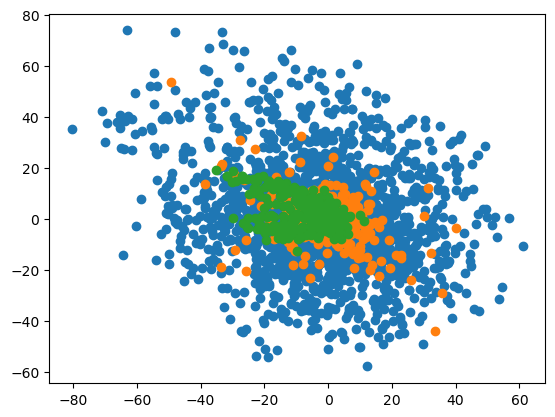

In [98]:
plt.scatter(pos_dm[:,0], pos_dm[:,1])
plt.scatter(pos_stars[:,0], pos_stars[:,1])
plt.scatter(pos_gas[:,0], pos_gas[:,1])
#plt.scatter(pos_sh[index_sh][0], pos_sh[index_sh][1], marker = '*', color = 'red')

In [99]:
R_bins = np.geomspace(1,100,20)

dist = np.linalg.norm(pos_stars, axis=1)
M_stars = np.array([np.sum( mass_stars[np.where(np.array(dist) < R)[0]] ) for R in R_bins])

dist = np.linalg.norm(pos_gas, axis=1)
M_gas = np.array([np.sum( mass_gas[np.where(np.array(dist) < R)[0]] ) for R in R_bins])

dist = np.linalg.norm(pos_dm, axis=1)
M_dm = np.array([mass_dm * len(np.where(np.array(dist) < R)[0]) for R in R_bins])

In [91]:
R_bins

array([  1.        ,   1.27427499,   1.62377674,   2.06913808,
         2.6366509 ,   3.35981829,   4.2813324 ,   5.45559478,
         6.95192796,   8.8586679 ,  11.28837892,  14.38449888,
        18.32980711,  23.35721469,  29.76351442,  37.92690191,
        48.32930239,  61.58482111,  78.47599704, 100.        ])

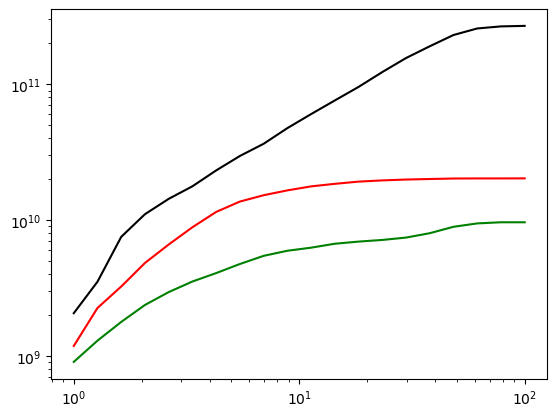

In [101]:
plt.plot(R_bins, M_dm, color = 'black')
plt.plot(R_bins, M_stars, color = 'red')
plt.plot(R_bins, M_gas, color = 'green')
plt.yscale('log')
plt.xscale('log')